In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

import os

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [4]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [5]:
drop_list = ['counter', 'id','time','pluginsJSHashed','canvasJSHashed',
             'webGLJsHashed','fontsFlashHashed']

df.drop(drop_list, axis = 1, inplace = True)

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import cross_validation as cv
from sklearn.model_selection import train_test_split

/Users/joel/.virtualenvs/ds_generic/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
df.head()

,addressHttp,userAgentHttp,acceptHttp,hostHttp,connectionHttp,encodingHttp,languageHttp,orderHttp,pluginsJS,platformJS,...,webGLJs,fontsFlash,resolutionFlash,languageFlash,platformFlash,adBlock,vendorWebGLJS,rendererWebGLJS,octaneScore,sunspiderTime
0,55d1fdecf97155f039d7ebdf163d713744cce141,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) ...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
1,d7620ba0d1c08ec6359fcd8275fa32efb0b4d17b,Mozilla/5.0 (Android 6.0.1; Mobile; rv:54.0) G...,"text/html,application/xhtml+xml,application/xm...",amiunique-backend,close,"gzip, deflate, br","de,de-DE;q=0.8,en-US;q=0.5,en;q=0.3",Upgrade-Insecure-Requests Referer Connection A...,,Linux armv7l,...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Flash not detected,Flash not detected,Flash not detected,Flash not detected,no,ARM,Mali-400 MP,,
2,f4d7978e4bf9a3180a96d6c7824c53cc13dd4d44,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"text/html,application/xhtml+xml,application/xm...",amiunique-backend,close,"gzip, deflate, br","en-US,en;q=0.8,de;q=0.6,de-DE;q=0.4",Upgrade-Insecure-Requests Referer Connection A...,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
3,ff3f9bf2797061dad81147e219e1bbda65e29df2,Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
4,ae2faaf7e9e248db79a0e28f28b434b0db29e2af,Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS


In [8]:
#fingerprint_target = df.userAgentHttp
#fingerprint_data = df.drop('userAgentHttp', axis=1)

%time X = pd.get_dummies(df)

#fingerprint_data = fingerprint.drop('userAgentHttp', axis=1)
#fingerprint_target = fingerprint.userAgentHttp

CPU times: user 4.68 s, sys: 582 ms, total: 5.26 s
Wall time: 5.27 s


In [9]:
# Code From: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

X_samp = X.sample(n=100)

# generate the linkage matrix
Z = linkage(X_samp, 'ward')

In [10]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X_samp))
c

0.79474014858966724

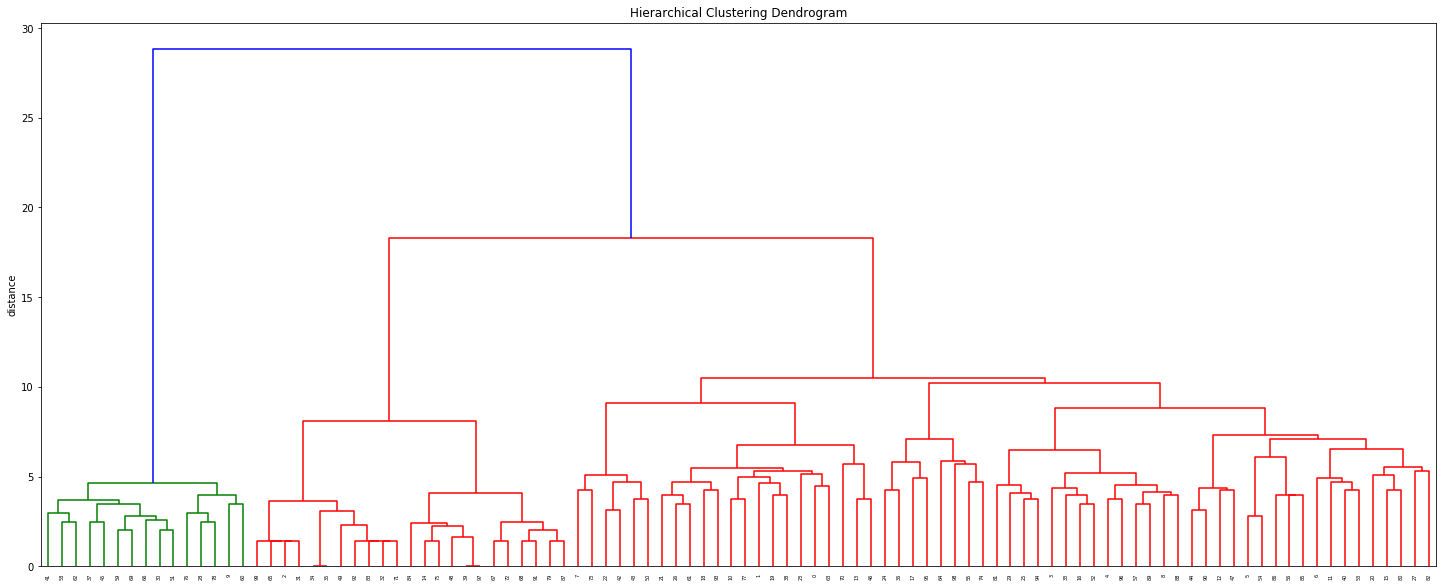

In [11]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
#    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [12]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values, added .astype(str)

from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

LE = MultiColumnLabelEncoder(columns = None)

In [13]:
# find a substring 'bot' in the userAgentHttp column (assuming that only good bots openly identify themselves as bots)
GoodBot = df['userAgentHttp'].str.contains("bot", case=False) # creates a column of Boolean True or False values
GoodBot = GoodBot.astype(int) # converts True/False to 1/0

NUM_GB = GoodBot.sum()

In [14]:
NUM_OF_CLUSTERS = 20
NUM_OF_CLUSTERS += 1

ClusterComparison = pd.DataFrame([i for i in range(2, NUM_OF_CLUSTERS)],
                                 columns=['ClusterSize'])

In [15]:
X = df #df.sample(n=100)

In [16]:
from sklearn.cluster import MiniBatchKMeans

MODEL_TO_USE = 'MBKM'

ClusterComparison[MODEL_TO_USE] = np.nan

for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
    MBKM = MiniBatchKMeans(n_clusters=cluster_size)

    pipeline = Pipeline([('LE', LE), ('MBKM', MBKM)])
    model = pipeline.fit(X)
    predicted = model.predict(X)
    
    tabs=pd.crosstab(predicted, GoodBot)
    #print(tabs, end='\n---\n')
    #print(tabs[1], end='\n---\n')
    #print(tabs[1].max())
    
    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [17]:
from sklearn.cluster import AgglomerativeClustering

MODEL_TO_USE = 'AC_WARD'

ClusterComparison[MODEL_TO_USE] = np.nan

for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
    AC = AgglomerativeClustering(n_clusters=cluster_size, linkage='ward')

    pipeline = Pipeline([('LE', LE), ('AC', AC)])
    model = pipeline.fit_predict(X)
    
    tabs=pd.crosstab(model, GoodBot)

    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [18]:
MODEL_TO_USE = 'AC_AVG'

ClusterComparison[MODEL_TO_USE] = np.nan

for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
    AC = AgglomerativeClustering(n_clusters=cluster_size, linkage='average')

    pipeline = Pipeline([('LE', LE), ('AC', AC)])
    model = pipeline.fit_predict(X)
    
    tabs=pd.crosstab(model, GoodBot)

    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [19]:
MODEL_TO_USE = 'AC_COMP'

ClusterComparison[MODEL_TO_USE] = np.nan

for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
    AC = AgglomerativeClustering(n_clusters=cluster_size, linkage='complete')

    pipeline = Pipeline([('LE', LE), ('AC', AC)])
    model = pipeline.fit_predict(X)
    
    tabs=pd.crosstab(model, GoodBot)

    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [20]:
#from sklearn.cluster import SpectralClustering

#MODEL_TO_USE = 'SC'

#ClusterComparison[MODEL_TO_USE] = np.nan

#for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
#    SC = SpectralClustering(n_clusters=cluster_size, n_jobs=-1)

#    pipeline = Pipeline([('LE', LE), ('SC', SC)])
#    model = pipeline.fit_predict(X)
    
#    tabs=pd.crosstab(model, GoodBot)

#    print(tabs)
    
#    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

#   ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [21]:
#from sklearn.cluster import FeatureAgglomeration

#MODEL_TO_USE = 'FA_WARD'

#ClusterComparison[MODEL_TO_USE] = np.nan

#for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
#    FA = FeatureAgglomeration(n_clusters=cluster_size, linkage='ward')

#    pipeline = Pipeline([('LE', LE), ('FA', FA)])
#    model = pipeline.fit(X)

#    tabs=pd.crosstab(model, GoodBot)
#    print(tabs)
#    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

#    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [22]:
from sklearn.cluster import Birch

MODEL_TO_USE = 'BIRCH'

ClusterComparison[MODEL_TO_USE] = np.nan

for cluster_size in range(2, NUM_OF_CLUSTERS):
#for cluster_size in range(2, 3):
    BI = Birch(n_clusters=cluster_size)

    pipeline = Pipeline([('LE', LE), ('BI', BI)])
    model = pipeline.fit_predict(X)
    
    tabs=pd.crosstab(model, GoodBot)
    
    max_contained = round((tabs[1].max() / NUM_GB) * 100, 2)

    ClusterComparison[MODEL_TO_USE].iloc[cluster_size - 2] = max_contained

In [23]:
ClusterComparison

,ClusterSize,MBKM,AC_WARD,AC_AVG,AC_COMP,BIRCH
0,2,55.74,61.75,57.92,56.83,60.66
1,3,39.89,38.25,42.08,43.17,39.34
2,4,30.60,38.25,35.52,41.53,39.34
3,5,35.52,38.25,31.69,25.68,39.34
4,6,30.05,32.24,31.69,24.04,33.33
5,7,32.24,32.24,31.69,19.67,33.33
6,8,27.32,32.24,31.69,19.67,33.33
7,9,26.23,32.24,31.69,19.67,33.33
8,10,27.32,32.24,31.69,19.67,32.24
9,11,25.68,32.24,28.42,19.67,32.24


In [ ]:
ClusterComparison.index = ClusterComparison.ClusterSize

ClusterComparison.drop(['ClusterSize'], axis=1, inplace=True)

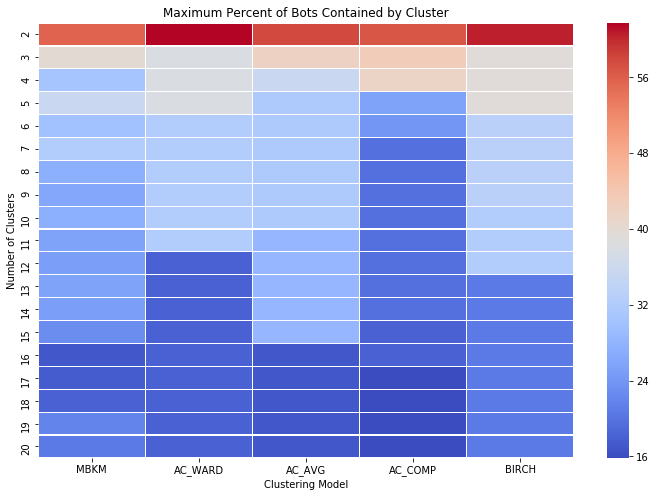

In [37]:
plt.figure(figsize = (12,8))
sns.heatmap(ClusterComparison, linewidths=0.2, cmap = 'coolwarm')

plt.title("Maximum Percent of Bots Contained by Cluster",)
plt.xlabel("Clustering Model")
plt.ylabel("Number of Clusters")
plt.draw()
plt.show()

In [39]:
from sklearn.cluster import DBSCAN

MODEL_TO_USE = 'DBSCAN'


DB = DBSCAN()

pipeline = Pipeline([('LE', LE), ('DB', DB)])
model = pipeline.fit_predict(X)

tabs=pd.crosstab(model, GoodBot)

In [40]:
print(tabs)

userAgentHttp      0    1
row_0                    
-1             18963  129
 0                 6    0
 1                14    0
 2                 0   20
 3                 0   10
 4                 7    0
 5                 8    0
 6                11    0
 7                 5    0
 8                 9    0
 9                12    0
 10                5    0
 11                9    0
 12                5    0
 13                9    0
 14                8    0
 15                5    0
 16                5    0
 17                5    0
 18                8    0
 19                8    0
 20               23    0
 21               13    0
 22               12    0
 23                6    0
 24                0    5
 25                6    0
 26               15    0
 27                9    0
 28                0    5
...              ...  ...
 217             103    0
 218              26    0
 219              25    0
 220              24    0
 221              31    0
 222        